# 3. Agri PV With Dictionary

So far, we explored the more custom-way of doing arrays and simulations in bifacial radiance.

In this tutorial, we will see an alternative option of using bifacial_radiance with the internal "Tracking Dictionary". The tracking dictionary offers a structure that keeps track of the hourly simulation data as one entry each, or of one angle each for a cumulative simulation. It is a better approach to modeling, but it does not currently offer the possibility to add objects extraneous to the simulation. 

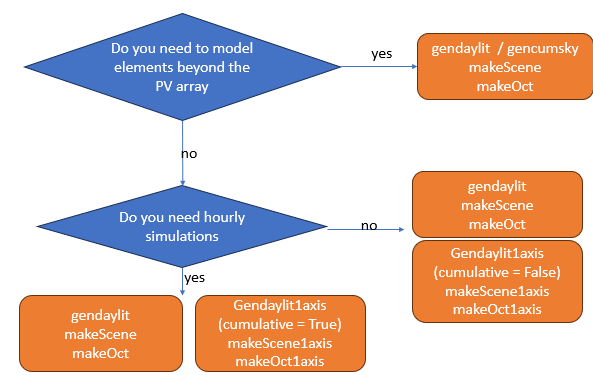

Steps:
1. Get weather data through NREL NSRDB API
2. Model tracking dictionary hourly

## 1. Solar Irradiance Data sources

### Where to get _Free_ Solar Irradiance Data?

There are many different sources of solar irradiance data. For your projects, these are some of the most common:

- [NSRDB](https://maps.nrel.gov/nsrdb-viewer/) - National Solar Radiation Database. You can access data through the website for many locations accross the world, or you can use their [web API](https://developer.nrel.gov/docs/solar/nsrdb/) to download data programmatically. An "API" is an ["application programming interface"](https://en.wikipedia.org/wiki/API), and a "web API" is a programming interface that allows you to write code to interact with web services like the NSRDB.

- [EPW](https://www.energy.gov/eere/buildings/downloads/energyplus-0) - Energy Plus Weather data is available for many locations accross the world. It's in its own format file ('EPW') so you can't open it easily in a spreadsheet program like Excel, but you can use [`pvlib.iotools.read_epw()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.read_epw.html) to get it into a dataframe and use it.

- [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/) - Free global weather data provided by the European Union and derived from many govermental agencies including the NSRDB. PVGIS also provides a web API. You can get PVGIS TMY data using [`pvlib.iotools.get_pvgis_tmy()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_pvgis_tmy.html).

- Perhaps another useful link: https://sam.nrel.gov/weather-data.html

### Where else can you get historical irradiance data?

There are several commercial providers of solar irradiance data. Data is available at different spatial and time resolutions. Each provider offers data under subscription that will provide access to irradiance (and other weather variables) via API to leverage in python.

* [SolarAnywhere](https://www.solaranywhere.com/)
* [SolarGIS](https://solargis.com/)
* [Vaisala](https://www.vaisala.com/en)
* [Meteonorm](https://meteonorm.com/en/)
* [DNV Solar Resource Compass](https://src.dnv.com/)


![NSRDB Example](images/tutorial_1_NSRDB_example.PNG)


### Fetching TMYs from the NSRDB

At the [NREL Developer Network](https://developer.nrel.gov/), there are [APIs](https://en.wikipedia.org/wiki/API) to a lot of valuable [solar resources](https://developer.nrel.gov/docs/solar/) like [weather data from the NSRDB](https://developer.nrel.gov/docs/solar/nsrdb/), [operational data from PVDAQ](https://developer.nrel.gov/docs/solar/pvdaq-v3/), or indicative calculations using [PVWatts](https://developer.nrel.gov/docs/solar/pvwatts/). In order to use these resources from NREL, you need to [register for a free API key](https://developer.nrel.gov/signup/). You can test out the APIs using the `DEMO_KEY` but it has limited bandwidth compared to the [usage limit for registered users](https://developer.nrel.gov/docs/rate-limits/). NREL has some [API usage instructions](https://developer.nrel.gov/docs/api-key/), but pvlib has a few builtin functions, like [`pvlib.iotools.get_psm3()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_psm3.html), that wrap the NREL API, and call them for you to make it much easier to use. Skip ahead to the next section to learn more. But before you do...

**Please pause now to visit https://developer.nrel.gov/signup/ and get an API key.**


<div class="alert alert-block alert-info"> <b>What is an API</b> </div>

What exactly is an API? Nowadays, the phrase is used interchangeably with a "web API" but in general an API is just a recipe for how to interface with a application programmatically, _IE_: in code. An API could be as simple as a function signature or its published documentation, _EG_: the API for the `solarposition` function is you give it an ISO8601 formatted date with a timezone, the latitude, longitude, and elevation as numbers, and it returns the zenith and azimuth as numbers.

A web API is the same, except the application is a web service, that you access at its URL using web methods. We won't go into too much more detail here, but the most common web method is `GET` which is pretty self explanatory. Look over the [NREL web usage instructions](https://developer.nrel.gov/docs/api-key/) for some examples, but interacting with a web API can be as easy as entering a URL into a browser. Try the URL below to _get_ the PVWatts energy output for a fixed tilt site in [Broomfield, CO](https://goo.gl/maps/awkEcNGzSur9Has18).

https://developer.nrel.gov/api/pvwatts/v6.json?api_key=DEMO_KEY&lat=40&lon=-105&system_capacity=4&azimuth=180&tilt=40&array_type=1&module_type=1&losses=10

In addition to just using your browser, you can also access web APIs programmatically. The most popular Python package to interact with web APIs is [requests](https://docs.python-requests.org/en/master/). There's also free open source command-line tools like [cURL](https://curl.se/) and [HTTPie](https://httpie.io/), and a popular nagware/freemium GUI application called [Postman](https://www.postman.com/).

**If you have an NREL API key please enter it in the next cell.**

In [3]:
NREL_API_KEY = None  # <-- please set your NREL API key here
# note you must use "quotes" around your key as it is a string.

if NREL_API_KEY is None:
       NREL_API_KEY = 'DEMO_KEY'  # OK for this demo, but better to get your own key

## Fetching TMYs from the NSRDB

The example TMY dataset used here is from an airport in North Carolina, but what if we wanted to model a PV system somewhere else? The NSRDB, one of many sources of weather data intended for PV modeling, is free and easy to access using pvlib. As an example, we'll fetch a TMY dataset for San Juan, Puerto Rico at coordinates [(18.4671, -66.1185)](https://goo.gl/maps/ZuYuKFxSpJ1z9HXX8). We use [`pvlib.iotools.get_psm3()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_psm3.html) which returns a Python dictionary of metadata and a Pandas dataframe of the timeseries weather data.

In [8]:
import pvlib

metdata, metadata = pvlib.iotools.get_psm3(
    latitude=18.4671, longitude=-66.1185,
    api_key=NREL_API_KEY,
    email='silvana.ovaitt@nrel.gov',  # <-- any email works here fine
    names='tmy', map_variables=True)
metadata

{'Source': 'NSRDB',
 'Location ID': '1493571',
 'City': '-',
 'State': '-',
 'Country': '-',
 'Time Zone': -4,
 'Local Time Zone': -4,
 'Dew Point Units': 'c',
 'DHI Units': 'w/m2',
 'DNI Units': 'w/m2',
 'GHI Units': 'w/m2',
 'Temperature Units': 'c',
 'Pressure Units': 'mbar',
 'Wind Direction Units': 'Degrees',
 'Wind Speed Units': 'm/s',
 'Surface Albedo Units': 'N/A',
 'Version': '3.2.0',
 'latitude': 18.45,
 'longitude': -66.1,
 'altitude': 6}

TMY datasets from the PSM3 service of the NSRDB are timestamped using the real year that the measurements came from. The [`pvlib.iotools.read_tmy3()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.read_tmy3.html) function had a `coerce_year` argument to force everything to align to a single dummy year, but [`pvlib.iotools.get_psm3()`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_psm3.html) doesn't have that feature. For convenience let's standardize the data to 1990 and then compare monthly GHI to the North Carolina location:

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

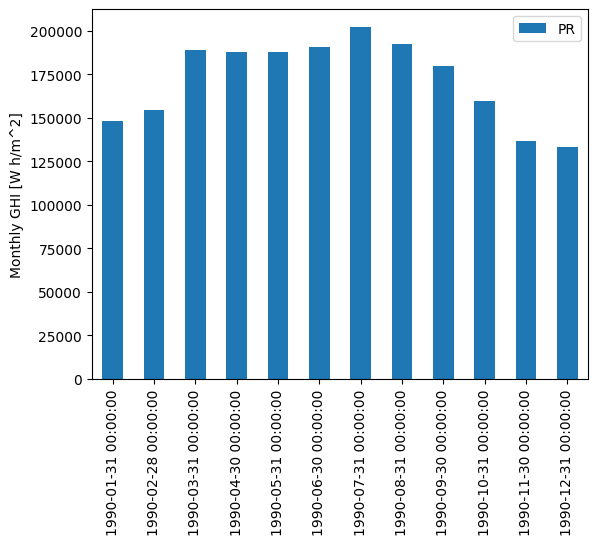

In [18]:
metdata['Year'] = 1990
metdata.index = pd.to_datetime(metdata[['Year', 'Month', 'Day', 'Hour']])

ghi_monthly = pd.DataFrame({
    'PR': metdata['ghi'].resample('M').sum(),
})

ghi_monthly.plot.bar()
plt.ylabel('Monthly GHI [W h/m^2]');

In [ ]:
    # -- establish tracking angles
    trackerParams = {'limit_angle':50,
                     'angledelta':5,
                     'backtrack':True,
                     'gcr':gcr,
                     'cumulativesky':False,
                     'azimuth': sazm,
                     'fixed_tilt_angle': fixed_tilt_angle,
                     }
    
            hub_height = 1.5
        pitch = 5
        sazm = 180  # Tracker axis azimuth
        modulename = 'PVmodule'
        bedsWanted = 3
        fixed_tilt_angle = None

In [ ]:
      radObj = br.RadianceObj(simpath,path)
    radObj.setGround(alb) 

    metData = radObj.NSRDBWeatherData(meta_dict, df_tmy, starttime=startdatenaive, 
                                      endtime=startdatenaive, coerce_year=2021)
    trackerdict = radObj.set1axis(**trackerParams)
    
    # -- generate sky   
    trackerdict = radObj.gendaylit1axis()
    print(trackerdict)
    print("LEN TRACKERDICT", len(trackerdict.keys()))
    try:
        tracazm = trackerdict[list(trackerdict.keys())[0]]['surf_azm']
        tractilt = trackerdict[list(trackerdict.keys())[0]]['surf_tilt']
    except:
        print("Issue with tracazm/tractilt on trackerdict for ", path )
        tracazm = np.NaN
        tractilt = np.NaN  

    sceneDict = {'pitch':pitch, 
                 'hub_height': hub_height,
                 'nMods': 19,
                 'nRows': 7,
                'tilt': fixed_tilt_angle,  
                'sazm': sazm
                 }

    modWanted = 10
    rowWanted = 4

    trackerdict = radObj.makeScene1axis(module=modulename,sceneDict=sceneDict)

    # -- build oct file
    trackerdict = radObj.makeOct1axis()

    # -- run analysis
    # Analysis for Module
    trackerdict = radObj.analysis1axis(trackerdict, customname = 'Module',
                                       sensorsy=9, modWanted=modWanted,
                                       rowWanted=rowWanted)
    try:
        trackerdict = radObj.calculateResults(bifacialityfactor=0.7, agriPV=False)
    except:
        print("**Error on trackerdict WHY!, skipping", gid, startdate)
        print("Trackerdict error path: " , results_path)
        print("TRACKERDICT Print:", radObj.trackerdict)
        results = [np.NaN] * 38
        #results = None
        with open(results_path, "wb") as fp:   #Pickling
            pickle.dump(results, fp)        
        return results

    ResultPVWm2Back = radObj.CompiledResults.iloc[0]['Grear_mean']
    ResultPVWm2Front = radObj.CompiledResults.iloc[0]['Gfront_mean']

It's not too surprising to see that Puerto Rico location is significantly sunnier than the one in North Carolina.

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).